In [2]:
%matplotlib inline
# %matplotlib widget
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ligo.skymap.plot # Used for geo aitoff projection
import csv
import pickle
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo # Used to calculate comoving dist
from astropy.table import Table, QTable
from astropy.io import fits # To handle FERMI data
from astropy import wcs
from astropy.wcs import WCS
from pytictoc import TicToc # Used to time Code
from multiprocessing import Pool # Used for multicore processing
from collections import Counter # Used to verify fermi data cleansing
from itertools import chain, combinations
from collections import defaultdict # Used to merge dictionaries
from matplotlib.colors import Normalize # To normalize z for plot coloring
from custom_functions import *
# import custom_functions as cf

# '''No longer necessary when using VSCode'''
# CLOCK = TicToc() # Create instance to time code blocks
PI = math.pi

In [3]:
# Read void table data from text file
voids = pd.read_table("void_data.txt", sep=",")  # Void data already parsed
voids.drop(columns=voids.columns[0], axis=1, inplace=True) # Removes redundant row counter column

# Void Data Processing

## Z distribution

Max z: 0.6906
Min z: 0.00394
Range: 0.6866599999999999 


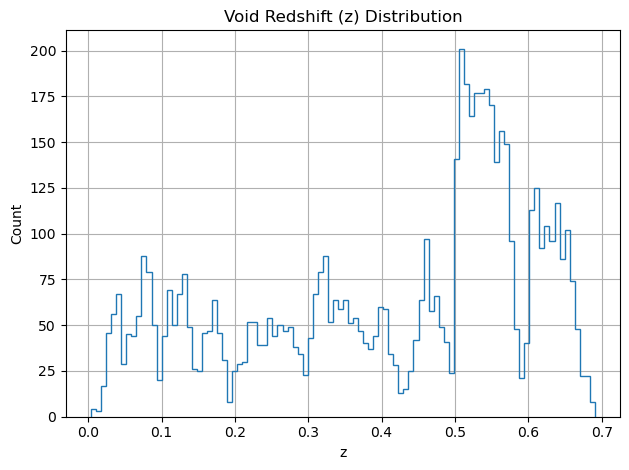

In [4]:
# Plot void z histogram
plt.hist(voids['z'], bins=100, histtype="step") # 100 bins chosen arbitrarily
plt.xlabel('z')
plt.ylabel('Count')
plt.title('Void Redshift (z) Distribution')
plt.grid()
plt.tight_layout()

# z range
max_z = voids['z'].max()
min_z = voids['z'].min()
print(f"Max z: {max_z}\nMin z: {min_z}\nRange: {max_z - min_z} ")

In [5]:
# Calculating comoving distance from z
# NOTE: WMAP9 uses H0 = 69.3 (km/s)/Mpc compared to 69.7 used to calculate h. This should be okay. 7/5/23
void_cmvd = cosmo.comoving_distance(voids['z']) # Comoving distance to void center
voids['cmvd_Mpc'] = void_cmvd.value # add it to data table

# Calculating effective radii in angular seperation units
H = 69.7 * ((u.km/u.s)/u.Mpc) # H0 hubble constant used for this study
h = H/(100 * ((u.km/u.s)/u.Mpc))

void_r = (voids['Reff']) / h.value # [Mpc]
voids['Reff_Mpc'] = void_r

#radius of voids in angular seperation
void_r_angs = np.arctan2(void_r,void_cmvd.value) * (180/math.pi) # Deg
voids['r_ang_deg'] = void_r_angs


## Checking for uniqueness in Void data

In [6]:
# Check for unique IDs
id_count = Counter(voids['ID']) # Uh oh we have a few duplicate ID's
keys = list(id_count)
duplicate_ids = [keys for keys, count in id_count.items() if count>1]

In [7]:
id_count;

In [8]:
duplicates = voids[voids.duplicated()]
# print(duplicates)
# But pandas method says they are all unique. 

In [9]:
seps = {}
problematic = {}
# Loop through duplicate id's and determine if their angular seperation is less
# than 5 degrees
# Save duplicate void id. seperation, radius of each void and their redshift
for id in duplicate_ids:
    # Find index
    mask = voids['ID'].isin([id])
    table = voids[mask][:]
    RAs = table[:]['RAdeg'].values * u.deg
    DEs = table[:]['DEdeg'].values * u.deg
    coords = SkyCoord(RAs, DEs)
    temp_seps = dist_w_skycoord(coords)
    
    seps[str(id)] = temp_seps
    if min(temp_seps) < 5:
        problematic[str(id)] = {'seps': temp_seps,
                                'radius': table[:]['r_ang_deg'].values,
                                'z': table[:]['z'].values}

In [10]:
# Display problematic void id's
problematic; # Two duplicate id's were problematic

In [11]:
# Not used anywhere else in the code. Will probably get deleted
# duplicate_mask = voids['ID'].isin(duplicate_ids)

In [12]:
# Void coordinates in celestial frame
void_coords_cel = SkyCoord(voids['RAdeg'].values*u.deg,
                       voids['DEdeg'].values*u.deg,
                       equinox='J2000')

In [13]:
# Out of curiosity. I wanted to see what a histogram for void seperations would
# look like. 
# void_seps = dist_w_skycoord(void_coords_cel) #plot super anisotropic


Notes on Void Catalog from 2017:
    ZOBOV void finding algorithm
    10,643 before "quality cuts"
    1,228 Voids after "quality cuts" 
    effective radii spanning 20-100 Mpc/h
    Uses SDSS DR 12 CMASS and LOWZ galaxy samples
    z: 0.2 - 0.43 LOWZ Sample cut
    z: 0.43 - 0.7 CMASS sample cut
    z: 0.2 - 0.7 total 

    
Notes on Void Catalog from 2012:
    z: 0.2 - 0.44
    Uses main sample and lumious red galaxy (LRG) from SDSS DR 7
    Effective radii 5 - 135 Mpc/h
    Modified Version of ZOBOV (parameter free)

    

# VHE Data Processing

## Cleaning Data

In [14]:
# import packages
fhl3 = fits.open('3FHL.fit')

In [15]:
# Determine where data is stored in fits file

# FERMI DATA USES FK5 FRAME
# fhl3.info() # Used to see scope of data
w = wcs.WCS(fhl3[1].header)
# print(w) # Used to find out what frame the data uses
# w.world_axis_physical_types

hdu = fits.open('3FHL.fit')[1]
wcs = WCS(hdu.header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 57236.967546 from DATE-END'. [astropy.wcs.wcs]


In [16]:
# Read in 3FHL Fits file
data = QTable.read('3FHL.fit', hdu=1) 

In [17]:
# data  # Used to see data table

In [18]:
# Clean 3FHL data to galactic sources only
class_data = data['CLASS']

# mask = (class_data == 'sbg    ') | \
#        (class_data == 'bll    ') | \
#        (class_data == 'fsrq   ') | \
#        (class_data == 'agn    ') | \
#        (class_data == 'rdg    ') | \
#        (class_data == 'bcu    ') # Ugly but it works

anti_mask = ~((class_data == 'psr    ') | \
              (class_data == 'PSR    ') | \
              (class_data == 'pwn    ') | \
              (class_data == 'PWN    ') | \
              (class_data == 'snr    ') | \
              (class_data == 'SNR    ') | \
              (class_data == 'hmb    ') | \
              (class_data == 'HMB    ') | \
              (class_data == 'BIN    ') | \
              (class_data == 'sfr    ') | \
              (class_data == 'SFR    ')
              ) # Ugly but it works

gal_src = data[anti_mask] # Cleaned 3FHL data that contains data from galactic sources only

In [19]:
Counter(gal_src['CLASS']); # Matches Table 2 in 3FHL Paper we are good to go

In [20]:
# Filtering out sources without Redshift information
z_data = gal_src['Redshift']
z_mask = ~np.ma.getmaskarray(z_data) # z data is float, if no z data, it is an np.ma.mask object
gal_src_wz = gal_src[z_mask] # Galactic Sources with redshift information

Max z: 2.5339999198913574
Min z: 0.003000000026077032
Range: 2.5309998989105225 


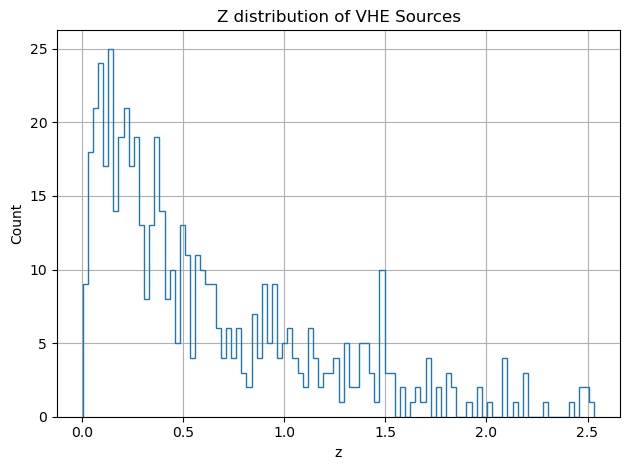

In [21]:
# Plots histogram of Gamma Ray Source Redshift Distribution
plt.hist(gal_src_wz['Redshift'], bins=100, histtype="step") # 100 bins chosen arbitrarily
plt.xlabel('z')
plt.ylabel('Count')
plt.title('Z distribution of VHE Sources')
plt.grid()
plt.tight_layout()

# z range
max_z = gal_src_wz['Redshift'].max()
min_z = gal_src_wz['Redshift'].min()
print(f"Max z: {max_z}\nMin z: {min_z}\nRange: {max_z - min_z} ")

Plot of Redshift distribution for extra galactic gamma ray sources

## Analysis

### Apply ± 10 deg mask to Fermi Data

In [22]:
ahh = gal_src_wz
temp =ahh[:]['Source_Name','RAJ2000', 'DEJ2000', 'Redshift', 'TEVCAT_FLAG']
work_vhe = temp.to_pandas() # Create GRS pandas table to work with throughout the code
work_vhe = work_vhe.rename(columns={'RAJ2000': 'RAdeg',
                                    'DEJ2000': 'DEdeg',
                                    'Redshift': 'z'}) # MUST BE CONSISTENT WITH CONVENCTION USED IN DATAPARSER

vhe_cmvd = cosmo.comoving_distance(work_vhe['z']) # Comoving distance to void center
work_vhe['cmvd_Mpc'] = vhe_cmvd.value # add it to data table

# Find sources in front of our furthest voids
mask_z = work_vhe['z'] <= max(voids.z)

# Keep those sources
work_vhe = work_vhe[mask_z] # After this mask. we drop to 367 sources

# reset the indices
work_vhe = work_vhe.reset_index(drop=True)

vhe_coords_cel = SkyCoord(work_vhe.RAdeg.values*u.deg, work_vhe.DEdeg.values * u.deg, equinox='J2000', frame='fk5')
vhe_coords_gal =  vhe_coords_cel.galactic # book keeping. Source coords in galactic coords
work_vhe['RAdeg_gal'] = vhe_coords_gal.l.deg
work_vhe['DEdeg_gal'] = vhe_coords_gal.b.deg
# work_vhe['RAdeg'] += 45


# Apply sdss footprint mask
m1 = ~get_mask(work_vhe,
                  RA_lo=0, RA_hi=110,
                  DE_lo=32)

m2 = ~get_mask(work_vhe,
                  DE_lo=65)
m3 = ~get_mask(work_vhe,
                   DE_hi=-10)
m4 = ~get_mask(work_vhe,
                  RA_lo=270,
                  RA_hi=315)
m5 = ~get_mask(work_vhe,
               RA_hi=270,
               RA_lo=262)
m6 = ~get_mask(work_vhe,
               RA_lo=265,
               DE_lo=37)
m7 =  ~get_mask(work_vhe,
                RA_lo=45,
                RA_hi=100)
m8 = ~get_mask(work_vhe,
               RA_lo=225,
               RA_hi=320,
               DE_hi=0)
m9 = ~get_mask(work_vhe,
               RA_lo = 45,
               RA_hi=182,
               DE_hi=0)
m10 = ~get_mask(work_vhe,
                RA_lo=315,
                DE_hi=-5)
m11 = ~get_mask(work_vhe,
                RA_lo=10,
                RA_hi=15,
                DE_hi=9)
m = get_ands([m1,
              m2,
              m3,
              m4,
              m5,
              m6,
              m7,
              m8,
              m9,
              m10,
              m11])
work_vhe = work_vhe[m].copy()

# Indices of gamma ray sources that fall outside of SDSS footprint
exclude = [21,
           98,
           90,
           107,
           279,
           277,
           278,
           241,
           257,
           325,
           45,
           40,
           33,
           35,
           31,
           36,
           29
           ]

# Final Gamma Ray Source table after table has been cleaned against galactic mask
# and data outside of SDSS footprint has been removed.
work_vhe = work_vhe.loc[~work_vhe.index.isin(exclude)]



In [23]:
# Display table
work_vhe

,Source_Name,RAdeg,DEdeg,z,TEVCAT_FLAG,cmvd_Mpc,RAdeg_gal,DEdeg_gal
3,b'3FHL J0018.6+2946 ',4.652533,29.782143,0.100,b'N',422.982362,114.479801,-32.550272
5,b'3FHL J0037.8+1239 ',9.461507,12.651176,0.089,b'N',377.399142,117.760924,-50.084057
12,b'3FHL J0109.1+1817 ',17.291544,18.284430,0.443,b'N',1722.784655,128.824926,-44.384373
14,b'3FHL J0112.1+2245 ',18.032927,22.755352,0.265,b'P',1077.800370,129.151333,-39.866364
17,b'3FHL J0114.8+1324 ',18.706766,13.404436,0.583,b'N',2186.405655,131.632717,-49.071776
...,...,...,...,...,...,...,...,...
347,b'3FHL J2314.0+1445 ',348.503143,14.754387,0.164,b'C',683.451557,90.529233,-41.906358
349,b'3FHL J2322.6+3436 ',350.663483,34.605709,0.098,b'C',414.712131,102.902685,-24.789353
356,b'3FHL J2338.9+2123 ',354.744965,21.396553,0.291,b'N',1175.980669,101.252166,-38.405682
358,b'3FHL J2343.6+3439 ',355.901154,34.651287,0.366,b'C',1451.554321,107.425531,-26.169645


In [24]:
# # work_data = gal_src # simply for bookkeeping in case we want to include sources that do not have z info

# vhe_coords_cel = SkyCoord(work_vhe.RAdeg.values*u.deg, work_vhe.DEdeg.values * u.deg, equinox='J2000', frame='fk5')
# vhe_coords_gal =  vhe_coords_cel.galactic # book keeping. Source coords in galactic coords
# work_vhe['RAdeg_gal'] = vhe_coords_gal.l.deg
# work_vhe['DEdeg_gal'] = vhe_coords_gal.b.deg


In [25]:
# Generate Skycoord Objects
# Skycoords of GRS in celestial
vhe_coords_cel = SkyCoord(work_vhe.RAdeg.values*u.deg, work_vhe.DEdeg.values * u.deg, equinox='J2000', frame='fk5')
vhe_coords_gal =  vhe_coords_cel.galactic # book keeping. Source coords in galactic coords

void_coords_gal = void_coords_cel.galactic # Moore bookkeeping. Skycoord of voids in galactic

seps = vhe_coords_cel.separation(vhe_coords_cel) # This returns the expected 0 seperation
Counter(vhe_coords_cel.separation(vhe_coords_cel)); # Confirming they are all 0 and array length matches source array


In [26]:
# Apply galactic mask
# # Find fermi data with |b| < 10
MASK_deg = 10 # Degrees. global constant
masked = True
if masked:
    mask_fermi = abs(vhe_coords_gal.b.value) <= MASK_deg

    # Keep the sources with |b| > 10
    vhe_coords_gal = vhe_coords_gal[~mask_fermi] # Drops 20 sources
    vhe_coords_cel = vhe_coords_gal.fk5 # Bookkeping. Go back to Celestial coordinates

### Plot Gamma-Ray Sources and Voids

/var/folders/pj/_3cv5_xd2sz143_b3_wm1xk40000gn/T/ipykernel_15340/406186901.py:39: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [30]  # Adjust the marker size for the Cosmic Voids label


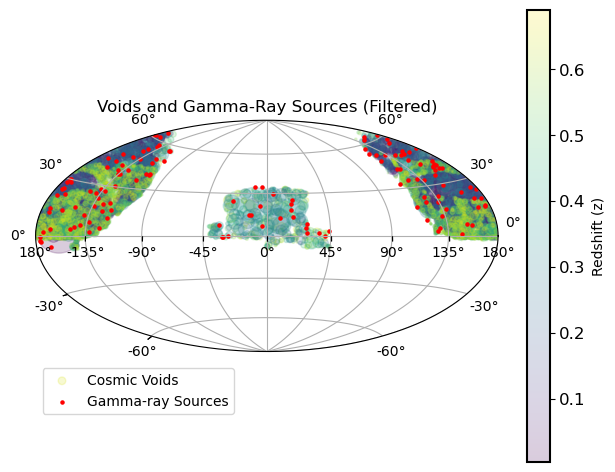

In [27]:

# Plot Sources in galactic frame
ax = plt.axes(projection="geo aitoff")
ax.grid()

r_ang = voids[:]['r_ang_deg']
z_values = voids['z']
norm = Normalize(vmin=min(z_values), vmax=max(z_values))

colormap = 'viridis' 

# Plot the cosmic voids with proper color mapping
scatter = ax.scatter(void_coords_cel.spherical.lon.deg, void_coords_cel.spherical.lat.deg,
                     transform=ax.get_transform('world'),
                     s=math.pi*r_ang**2,
                     marker='o',
                     label='Cosmic Voids',
                     c=voids['z'],  # Use the redshift values directly
                     cmap=colormap,  # Set the colormap
                     alpha=0.2)

# Set color limits to match data range
vmin = min(voids['z'])
vmax = max(voids['z'])
scatter.set_clim(vmin, vmax)
ax.scatter(vhe_coords_cel.spherical.lon.deg, vhe_coords_cel.spherical.lat.deg,
           transform=ax.get_transform('world'),
           marker="o",
           facecolor='red',
           s =5,
           label='Gamma-ray Sources'
          )


# Add a color bar using the scatter plot as the mappable
colorbar = plt.colorbar(scatter, ax=ax, label='Redshift (z)')
colorbar.ax.tick_params(labelsize=12)  # Adjust font size of color bar labels
colorbar.outline.set_linewidth(1.5)     # Set color bar outline linewidth
legend = plt.legend(loc="lower left", bbox_to_anchor=(0.0, -0.3), bbox_transform=ax.transAxes)
legend.legendHandles[0]._sizes = [30]  # Adjust the marker size for the Cosmic Voids label

plt.subplots_adjust(bottom=0.15, right=0.8)  # Increase the bottom and right margins

plt.title(f"Voids and Gamma-Ray Sources (Filtered)")
plt.tight_layout(pad=1)



plt.show()

# Voidiness Calculation

In [28]:
# One of the first attempts. Keeping it for posterity
# vhes ={}
# # ks = []
# for i in range(len(work_voids)):
#     temp_vhe = work_vhe.copy()
#     void_ra, void_de, r_ang_deg, z, cmvd, void_reff = work_voids.loc[i,['RAdeg', 'DEdeg', 'r_ang_deg', 'z', 'cmvd_Mpc', 'Reff_Mpc']]
#     temp_vhe['temp_RA'] = ((temp_vhe.RAdeg - void_ra)) + r_ang_deg 
#     temp_vhe['temp_DE'] = ((temp_vhe.DEdeg - void_de)) + r_ang_deg

#     pos_mask = temp_vhe.temp_RA >= 0
#     temp_vhe = temp_vhe[pos_mask][:]
#     pos_mask = temp_vhe.temp_DE >= 0
#     temp_vhe = temp_vhe[pos_mask][:]


#     inbounds = temp_vhe.temp_RA <= 2*r_ang_deg
#     temp_vhe = temp_vhe[inbounds][:]


#     inbounds = temp_vhe.temp_DE <= 2*r_ang_deg
#     temp_vhe = temp_vhe[inbounds][:]


#     # check coord actually falls inside circle.
#     temp_vhe = temp_vhe.reset_index(drop=True) # Reset indexing so 0 indexing works agai
#     temp_void_coord = SkyCoord(void_ra * u.deg, void_de *u.deg)

    
#     for k in range(len(temp_vhe)):
#         ra, de = temp_vhe.loc[k, ['RAdeg', 'DEdeg']] # deg
#         coord = SkyCoord(ra*u.deg, de*u.deg)

#         # COLAT
#         v_th = 90 - void_de
#         s_th = 90 - de

#         v_th *= (math.pi)/180
#         s_th *= (math.pi)/180
        

#         void_ra *= math.pi/180
#         ra *= math.pi/180

#         min_dist = cmvd - void_reff
#         vhe_dist = temp_vhe.loc[k, 'cmvd_Mpc']
        
#         rv = cmvd *  np.array([    1, v_th, np.sin(v_th)* void_ra])
#         rs = vhe_dist  * np.array([1, s_th, np.sin(s_th)* ra])

#         rvx, rvy, rvz = vector_transform(rv[0], rv[1], rv[2], v_th, void_ra, fromto='cart')
#         rsx, rsy, rsz = vector_transform(rs[0], rs[1], rs[2], s_th, ra, fromto='cart')

#         rv = np.array([rvx, rvy, rvz])
#         rs = np.array([rsx, rsy, rsz])

#         # dist = np.arccos(np.dot(rs,rv)/(mag(rs)*mag(rv)))* (180/math.pi)
#         dist = coord.separation(temp_void_coord)
#         ang_dist = dist.deg
#         if ang_dist < r_ang_deg:
#             if vhe_dist > min_dist: # Passed all criteria
#                 if vhe_dist > (min_dist+ 2*void_reff): # Completely behind void
#                     # COLAT
#                     # v_th = 90 - void_de
#                     # s_th = 90 - de

#                     # v_th *= (math.pi)/180
#                     # s_th *= (math.pi)/180
                    

#                     # void_ra *= math.pi/180
#                     # ra *= math.pi/180
                    
#                     # rv = cmvd *  np.array([1, v_th, np.sin(v_th)*void_ra])
#                     # rs = vhe_dist  * np.array([1, s_th, np.sin(s_th)* ra])

#                     # rvx, rvy, rvz = vector_transform(rv[0], rv[1], rv[2], v_th, void_ra, fromto='cart')
#                     # rsx, rsy, rsz = vector_transform(rs[0], rs[1], rs[2], s_th, ra, fromto='cart')

#                     # rv = np.array([rvx, rvy, rvz])
#                     # rs = np.array([rsx, rsy, rsz])

#                     # voidy_los = calc_void_chord(rv, rs, void_reff)
#                     little_d = dist.rad * cmvd
#                     voidy_los = other_voidy_calc(little_d, void_reff)

#                     # if little_d > void_reff:
#                     #     raise Exception('cry now')
#                     # if math.isnan(voidy_los):
#                     #     raise Exception('debugging shit pls hold')
#                     #     #  continue
#                     try:
#                         vhes[str(temp_vhe.loc[k]['Source_Name'])] += [voidy_los]
#                     except:
#                         vhes[str(temp_vhe.loc[k]['Source_Name'])] = [voidy_los]
   
#                 else: # Inside Void
#                     voidy_los = voidy_inside(rs, rv, void_reff)
#                     try:
#                         vhes[str(temp_vhe.loc[k]['Source_Name'])] += [voidy_los]
#                     except:
#                         vhes[str(temp_vhe.loc[k]['Source_Name'])] = [voidy_los]




In [29]:
# # One of the first attempts. Keeping for posterity
# vhes ={}
# # ks = []
# for i in range(len(work_voids)):
#     temp_vhe = work_vhe.copy() # super weird bug. without copy(). code was yeager bombing RAdeg data
#     void_ra, void_de, r_ang_deg, z, cmvd, void_reff = work_voids.loc[i,['RAdeg', 'DEdeg', 'r_ang_deg', 'z', 'cmvd_Mpc', 'Reff_Mpc']]

#     temp_void_coord = SkyCoord(void_ra * u.deg, void_de *u.deg)

#     ra = temp_vhe['RAdeg'].values
#     de = temp_vhe['DEdeg'].values # deg

#     temp_vhe_coord = SkyCoord(ra*u.deg, de*u.deg)
#     dist = temp_vhe_coord.separation(temp_void_coord).deg       

#     # ra = temp_vhe.loc[k, 'RAdeg']
#     v_th = 90 - void_de
#     s_th = 90 - de

#     v_th *= (math.pi)/180
#     s_th *= (math.pi)/180

#     void_ra *= math.pi/180
#     ra *= math.pi/180

#     min_dist = cmvd - void_reff
#     vhe_dist = temp_vhe['cmvd_Mpc'].values
    
#     rv = cmvd *  np.array([1, v_th, np.sin(v_th)* void_ra])
#     dist = np.zeros(len(de))
#     # break
#     for j in range(len(temp_vhe)):
#         rs = vhe_dist[j] * np.array([1, s_th[j], np.sin(s_th[j])* ra[j]])
#         dist[j] = np.arccos(np.dot(rs,rv)/(mag(rs)*mag(rv)))*(180/math.pi)


#     temp_vhe['dists'] = dist
#     mask = temp_vhe['dists'] < r_ang_deg
#     temp_vhe = temp_vhe[mask]
#     temp_vhe = temp_vhe.reset_index(drop=True)

#     # if len(temp_vhe) > 0:
#     #     break
    
#     for k in range(len(temp_vhe)):
#         # COLAT


#         # rvx, rvy, rvz = vector_transform(rv[0], rv[1], rv[2], v_th, void_ra, fromto='cart')
#         # rsx, rsy, rsz = vector_transform(rs[0], rs[1], rs[2], s_th, ra, fromto='cart')
#         # rv = np.array([rvx, rvy, rvz])
#         # rs = np.array([rsx, rsy, rsz])

#         # dist = np.arccos(np.dot(rs,rv)/(mag(rs)*mag(rv)))* (180/math.pi)
#         # dist = coord.separation(temp_void_coord)
#         # dist = dist.deg
#         vhe_dist = temp_vhe.loc[k, 'cmvd_Mpc']
#         if vhe_dist > min_dist: # Passed all criteria
#             if vhe_dist > (cmvd+void_reff): # Completely behind void

#                 voidy_los, _ = calc_void_chord(rv, rs, void_reff)
#                 if math.isnan(voidy_los):
#                     raise Exception('debugging shit pls hold')
#                     #  continue
#                 try:
#                     vhes[str(temp_vhe.loc[k]['Source_Name'])] += [voidy_los]
#                 except:
#                     vhes[str(temp_vhe.loc[k]['Source_Name'])] = [voidy_los]

#             else: # Inside Void
#                 try:
#                     vhes[str(temp_vhe.loc[k]['Source_Name'])] += ['IDK BRUH']
#                 except:
#                     vhes[str(temp_vhe.loc[k]['Source_Name'])] = ['IDK BRUH']


In [30]:
# Attempt to plot Source and voids
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Create a figure and 3D axis
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Create a sphere
# u = np.linspace(0, 2 * np.pi, 100)
# v = np.linspace(0, np.pi, 100)
# sphere_r = 1 
# x = sphere_r* np.outer(np.cos(u), np.sin(v))
# y = sphere_r * np.outer(np.sin(u), np.sin(v))
# z = sphere_r * np.outer(np.ones(np.size(u)), np.cos(v))

# # Plot the sphere
# ax.plot_surface(x, y, z, color='b', alpha=0.3)

# # Define a point
# point = np.array([0.5, 0.5, 0.5])

# # Plot the point
# ax.scatter(point[0], point[1], point[2], color='r', marker='o')

# # Set labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('3D Plot with Sphere and Point')

# plt.show()


In [31]:
# # I dont remember what this was for
# # %matplotlib widget
# ax = plt.axes(projection="geo aitoff")
# ax.grid()
# # Plot the sources
# ax.scatter(temp_void_coord.spherical.lon.deg, temp_void_coord.spherical.lat.deg,
#            transform=ax.get_transform('world'),
#            marker="o",
#            facecolor='red',
#            s = math.pi*r_ang_deg**2, # s is area of dots i think.
#            alpha=0.3, 
#            label='Void'
#           )
# ax.scatter(temp_vhe_coord.spherical.lon.deg, temp_vhe_coord.spherical.lat.deg,
#            transform=ax.get_transform('world'),
#            s = 1,
#            marker='o',
#            label='source')
# plt.legend(loc="lower right")
# plt.title(f"Problematic Chord Distances")
# plt.show()

#### CURRENT METHOD

In [32]:
# Calculate voidiness using the average chord length of random chords. CURRENT METHOD
# Allocate memory
vhes = {}
bad_vhes = {}
work_voids = voids.copy() # Create working copy of table to avoid accidental deletion of data
# The data is saved on a source index basis. 
#Loop through each void
# TODO: I AM POTENTIALLY SAVING THE WRONG GRS INDEX NUMBER
for void_idx in list(work_voids.index):
    temp_vhe = work_vhe.copy() # super weird bug. without copy(). code was yeager bombing RAdeg data

    # Get current void data ----------------------------------------------------
    void_ra, void_de = work_voids.loc[void_idx, ['RAdeg', 'DEdeg']]
    void_r_deg, z, void_cmvd = work_voids.loc[void_idx, ['r_ang_deg','z','cmvd_Mpc']]
    void_r_mpc = work_voids.loc[void_idx, 'Reff_Mpc']
    #---------------------------------------------------------------------------

    # Create SkyCoord for current void.
    temp_v_coord = SkyCoord(void_ra * u.deg, void_de * u.deg, 
                            equinox='J2000').transform_to('fk5')
    
    # Assuming void coordinates are given in ICRS frame. 
    # This is to make everything consistent with fermi coordinates. Doesnt seem
    # like it will make a difference.

    void_ra, void_de = temp_v_coord.ra.deg, temp_v_coord.dec.deg

    # Filter by comoving distance
    temp_vhe['cmvd_mask'] = temp_vhe.cmvd_Mpc > (void_cmvd - void_r_mpc)
    temp_vhe = temp_vhe[temp_vhe.cmvd_mask.values]

    # Filter by angular distance ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    ## Create SkyCoord for sources----------------------------------------------
    s_ra = temp_vhe['RAdeg'].values # 
    s_de = temp_vhe['DEdeg'].values # deg
    temp_s_coord = SkyCoord(s_ra * u.deg, s_de * u.deg, frame = 'fk5')
    #---------------------------------------------------------------------------

    ## Measure angular distance and filter
    temp_vhe['ang_dist'] = temp_s_coord.separation(temp_v_coord).deg

    # If true, GRS falls within void angular radius
    temp_vhe['r_ang_mask'] = temp_vhe.ang_dist < void_r_deg

    #---------------------------------------------------------------------------

    if any(temp_vhe.r_ang_mask.values):
        # Save a copy of vhe sources that fall within the void's angular radius
        good_vhe = temp_vhe[temp_vhe.r_ang_mask.values].copy()
        good_vhe['behind'] = good_vhe.cmvd_Mpc > (void_cmvd + 2*void_r_mpc)

        # loop through the sources that passed
        for src_idx  in list(good_vhe.index):

            # Determine if GRS is behind void
            behind = good_vhe.loc[src_idx, 'behind']

            # If GRS is behind the void estimate voidichord and save
            if behind:
                # Estimate Voidichord 
                Cv_i = (4/3) * void_r_mpc

                # If GRS has been previously saved
                if src_idx in vhes: 
                    data = vhes[src_idx]
                    data.setdefault('void_idx', []).append(void_idx)
                    data.setdefault('Cv', []).append(Cv_i)
                    # data.setdefault('void_idx', []).append(void_idx)
                    vhes[src_idx] = data
                else:
                    vhes[src_idx] = {'Cv':[Cv_i],
                                     'void_idx': [void_idx]}
                    
            # else:
            #     Cv = calc_d_inside(rs, rv)
            #     if math.isnan(Cv):
            #         temp_dict =  {'rs': rs,
            #                       'rv': rv,
            #                       'Cv': Cv,
            #                       'void_idx': void_idx,
            #                       'source_idx': src_idx}
            #         bad_vhes = add_to_dict(bad_vhes, name, temp_dict)
            #     else:
            #         vhes = add_to_dict(vhes, name, Cv)



In [33]:
# vhes = {}
# bad_vhes = {}
# work_voids = voids.copy()
# for void_idx in list(work_voids.index):
#     temp_vhe = work_vhe.copy() # super weird bug. without copy(). code was yeager bombing RAdeg data
#     void_ra, void_de = work_voids.loc[void_idx, ['RAdeg', 'DEdeg']]
#     void_r_deg, z, void_cmvd = work_voids.loc[void_idx, ['r_ang_deg','z','cmvd_Mpc']]
#     void_r_mpc = work_voids.loc[void_idx, 'Reff_Mpc']
#     temp_v_coord = SkyCoord(void_ra * u.deg, void_de * u.deg, 
#                             equinox='J2000').transform_to('fk5')
#     # Assuming void coordinates are given in ICRS frame. 
#     # This is to make everything consistent with fermi coordinates. Doesnt seem
#     # like it will make a difference.
#     # temp_v_coord = temp_v_coord.transform_to('fk5')
#     void_ra, void_de = temp_v_coord.ra.deg, temp_v_coord.dec.deg


#     # Filter by comoving distance
#     temp_vhe['cmvd_mask'] = temp_vhe.cmvd_Mpc > (void_cmvd - void_r_mpc)
#     temp_vhe = temp_vhe[temp_vhe.cmvd_mask.values]

#     # Filter by angular distance
#     ## Create Sky Coord
#     s_ra = temp_vhe['RAdeg'].values
#     s_de = temp_vhe['DEdeg'].values # deg
#     temp_s_coord = SkyCoord(s_ra * u.deg, s_de * u.deg, frame = 'fk5')

#     ## Measure angular distance and filter
#     temp_vhe['ang_dist'] = temp_s_coord.separation(temp_v_coord).deg
#     temp_vhe['r_ang_mask'] = temp_vhe.ang_dist < void_r_deg

#     if any(temp_vhe.r_ang_mask.values):
#         good_vhe = temp_vhe[temp_vhe.r_ang_mask.values].copy()
#         good_vhe['behind'] = good_vhe.cmvd_Mpc > (void_cmvd + 2*void_r_mpc)
#         for src_idx  in list(good_vhe.index):
#             ang_dist = good_vhe.loc[src_idx, 'ang_dist']
#             behind = good_vhe.loc[src_idx, 'behind']
#             name = str(src_idx)
#             ra, de, cmvd = good_vhe.loc[src_idx, ['RAdeg','DEdeg', 'cmvd_Mpc']]
#             rs = make_astro_vec2(cmvd, ra, de)
#             # rs = vector_transform(rs, th=to_colat_rad(de), ph=ra*(math.pi/180),
#             #                       fromto = 'cart')
#             rv = make_astro_vec2(void_cmvd, void_ra, void_de)
#             # rv = vector_transform(rv, th=to_colat_rad(void_ra), ph = void_ra*(math.pi/180),
#             #                       fromto='cart')
#             newdata = {}
#             if behind:
#                 Cv = calc_void_chord(rv, rs, void_r_mpc,ang_dist)

#                 # newdata = {'r':(4/3) * void_r_mpc,
#                 #            'void_ids': void_idx }

#                 if src_idx in vhes:
#                     data = vhes[src_idx]
#                     data.setdefault('void_idx', []).append(void_idx)
#                     # data.setdefault('Cv', []).append((4/3) * void_r_mpc)
#                     data.setdefault('Cv', []).append(Cv)
#                     # data.setdefault('void_idx', []).append(void_idx)
#                     vhes[src_idx] = data
#                 else:
#                     vhes[src_idx] = {'Cv':[Cv],
#                                      'void_idx': [void_idx]}
#                 # vhes = add_to_dict(vhes, src_idx, (4/3) * void_r_mpc)
#             else:
#                 Cv = voidy_inside(rs, rv,void_r_mpc)
#                 if math.isnan(Cv):
#                     temp_dict =  {'rs': rs,
#                                   'rv': rv,
#                                   'Cv': Cv,
#                                   'void_idx': void_idx,
#                                   'source_idx': src_idx}
#                     bad_vhes = add_to_dict(bad_vhes, name, temp_dict)
#                 else:
#                     if src_idx in vhes:
#                         data = vhes[src_idx]
#                         data.setdefault('void_idx', []).append(void_idx)
#                         # data.setdefault('Cv', []).append((4/3) * void_r_mpc)
#                         data.setdefault('Cv', []).append(Cv)
#                         # data.setdefault('void_idx', []).append(void_idx)
#                         vhes[src_idx] = data
#                     else:
#                         vhes[src_idx] = {'Cv':[Cv],
#                                         'void_idx': [void_idx]}



In [34]:
bad_vhes

{}

#### Find overlapping voids

In [35]:
# Create new row to store the GRS's incident void id's
work_vhe['Assoc_V_IDs'] = np.nan
work_vhe['Assoc_V_IDs'] =  work_vhe['Assoc_V_IDs'].astype('object') # Cast column to save objects
for key, _ in vhes.items():
    cv_voids = vhes[key]
    v_idx = cv_voids['void_idx']
    v_ids = list(work_voids.loc[v_idx, 'ID'].values)
    work_vhe.at[int(key), 'Assoc_V_IDs'] = v_ids

In [36]:
# Output excel of GRS with the incident voids
filepath = './outputTables/Source_void_coincidences_Table.xlsx'  # Add the .xlsx extension

# Create an Excel writer object
# excel_writer = pd.ExcelWriter(filepath, engine='xlsxwriter')
work_vhe.to_excel(excel_writer=filepath)

In [37]:
overlap_v = {}
for key, dct in vhes.items():
    void_idx = dct['void_idx']
    combos = list(combinations(void_idx, 2))
    for combo in combos:
        v1_idx = combo[0]
        v2_idx = combo[1]
        r1 = work_voids.loc[v1_idx]['Reff_Mpc']
        r2 = work_voids.loc[v2_idx]['Reff_Mpc']

        vec1 = get_void_vec(v1_idx, work_voids)
        vec2 = get_void_vec(v2_idx, work_voids)
        d = vec1 - vec2
        if mag(d) < (r1 + r2):
        # if True:
            # print(mag(d), r1 + r2)
            overlap_v.setdefault('v_idx', []).append(combo)


        

In [38]:
len(overlap_v['v_idx'])

866

In [39]:
lapped_voids = overlap_v['v_idx'] # overlapped voids
for key, _ in vhes.items():
    data = vhes[key]
    void_idx = data['void_idx']
    combos = list(combinations(void_idx, 2))
    if len(combos) > 0:
        trouble = np.array([combo in lapped_voids for combo in combos]) # Find problematic void combinations in assoc voids list
        prob_v_idx= np.array(combos)[trouble]
        Cvs = data['Cv']
        losers = []
        temp_avgs = []
        for p_v_idx in prob_v_idx:
            Cv_idx1 = void_idx.index(p_v_idx[0])
            Cv_idx2 =  void_idx.index(p_v_idx[1])
            Cv1 = Cvs[Cv_idx1]
            Cv2 = Cvs[Cv_idx2]
            if Cv1 < Cv2:
                losers.append(Cv_idx1)
            else:
                losers.append(Cv_idx2)
            # losers.append(Cv_idx1)
            # losers.append(Cv_idx2)
            # temp_avgs.append(np.mean([Cv1, Cv2]))
        vhes[key]['Cv'] = [Cvs[i] for i in range(len(Cvs)) if i not in losers]
        # data.setdefault('Cv', []).extend(temp_avgs[:])
        # vhes[key] = data
        break
        

    




In [40]:
vhes

{204: {'Cv': [133.8995695839311,
   541.5074127211859,
   36.00191296030607,
   23.797226207556186,
   125.47106647537062],
  'void_idx': [38,
   778,
   967,
   978,
   1025,
   2252,
   2271,
   2344,
   2448,
   3044,
   3338,
   3408,
   3573]},
 238: {'Cv': [108.18747010999519,
   114.50023912003823,
   107.6709708273553,
   12.08990913438546,
   8.646580583452891,
   43.003347680535626,
   56.049736967957905,
   36.15494978479195,
   103.35724533715924,
   34.03156384505021,
   29.7274031563845,
   33.66810138689622,
   22.228598756575796,
   13.830703012912481,
   26.188426590148246,
   24.83022477283596,
   151.86991869918697,
   122.98421807747488,
   75.14108082257292,
   64.48589191774269,
   102.78335724533714,
   80.61214729794355,
   106.36059301769487,
   84.6676231468197,
   45.719751315160195,
   41.12864658058345],
  'void_idx': [104,
   984,
   1058,
   2366,
   2400,
   2467,
   2518,
   2661,
   2790,
   2938,
   2960,
   2987,
   3036,
   3092,
   3170,
   3299,
 

In [41]:
# TODO: Instead of saving into a seperate dictionary just save it as an additional
# entry in vhes dictionary
voidiness = {}
TEV_voidiness = {}
over1_idx= []
src_keys = list(vhes.keys())
TEV_src_idx = []
flags = ["b'P'","b'E'"]

for idx in list(work_vhe.index):
    # print(type(idx))
    if idx in src_keys:
        total_d = work_vhe.loc[int(idx)]['cmvd_Mpc']
        Cvs = vhes[idx]['Cv']
        # if len(Cvs) > 2:
        #     print(Cvs,'\n')
        voidiness_i = sum(Cvs)/total_d
    else:
        voidiness_i = 0
    # break
    voidiness[idx] = voidiness_i
    
    if str(work_vhe.loc[idx, 'TEVCAT_FLAG']) in flags:
        TEV_voidiness[idx] = voidiness_i
    
    
    


In [42]:
l_all = len(voidiness)
l_TEV = len(TEV_voidiness)

### Voidiness Histogram

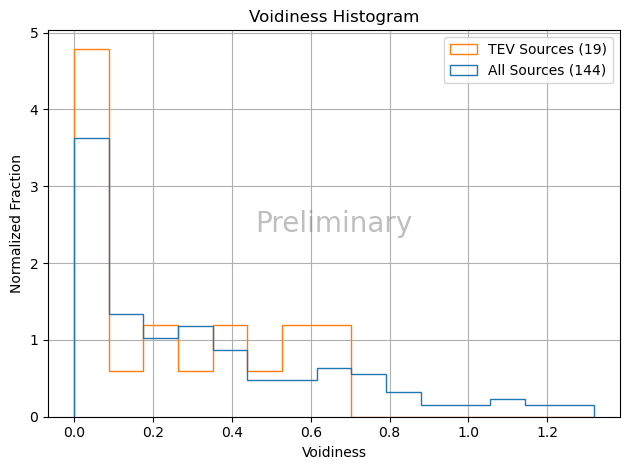

In [43]:

voidiness_list = [item for _, item in voidiness.items()]
TEV_voidiness_list = [item for _, item in TEV_voidiness.items()]
# print(max(voidiness_list))
plot_hist_watermark([voidiness_list, TEV_voidiness_list], bins=15,
          xlabel='Voidiness',
          ylabel='Normalized Fraction',
          title='Voidiness Histogram',
          watermark_text='Preliminary',
          label=[f'All Sources ({l_all})', f'TEV Sources ({l_TEV})'],
          density=True)
# ax.text(0.5, 0.5, 'created with matplotlib', transform=ax.transAxes,
#         fontsize=40, color='gray', alpha=0.5,
        # ha='center', va='center', rotation=30)

### Voidiness Line Plots

In [44]:
# Testing logic to splice up Large list into smaller list and handling the 
# remaining elements
sub_len = 10
l = range(0,101)
n_full_rows = len(l)//sub_len
rem = len(l)%sub_len

new_l = []
for i in range(n_full_rows):
    new_l.append(l[0+sub_len*i:sub_len*(i+1)])

if rem:
    new_l.append(l[-rem:])
  

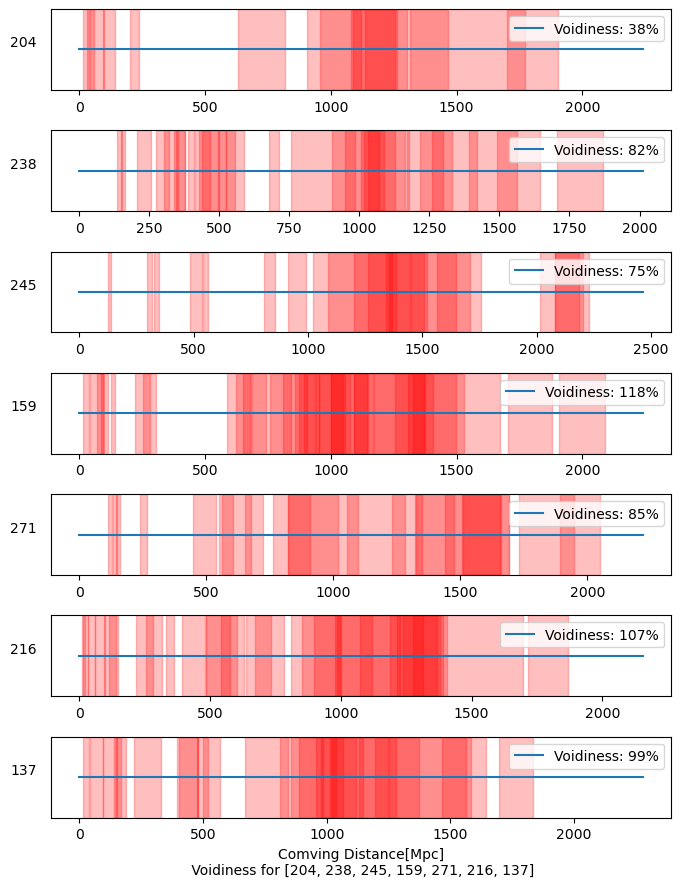

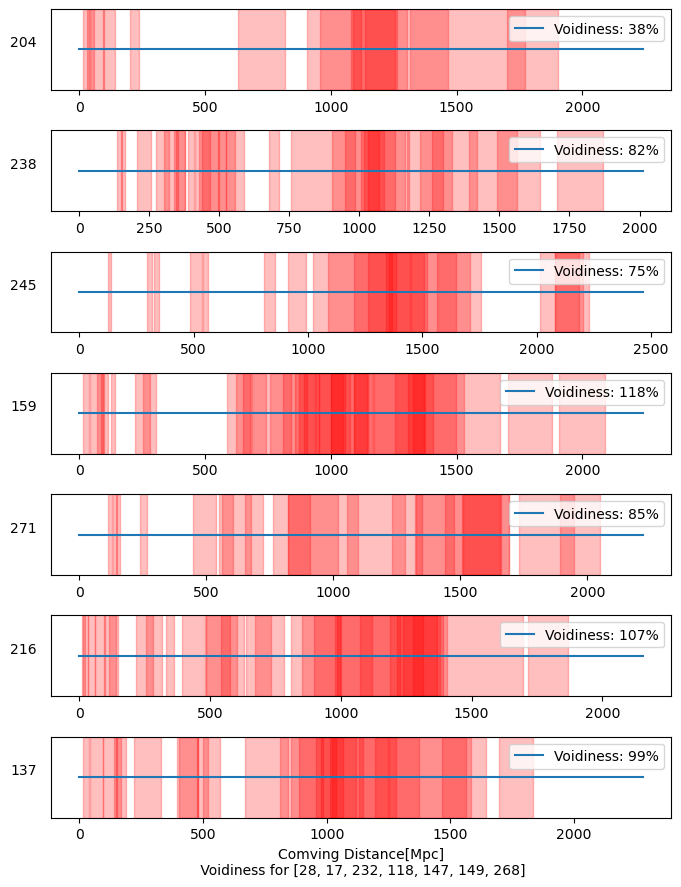

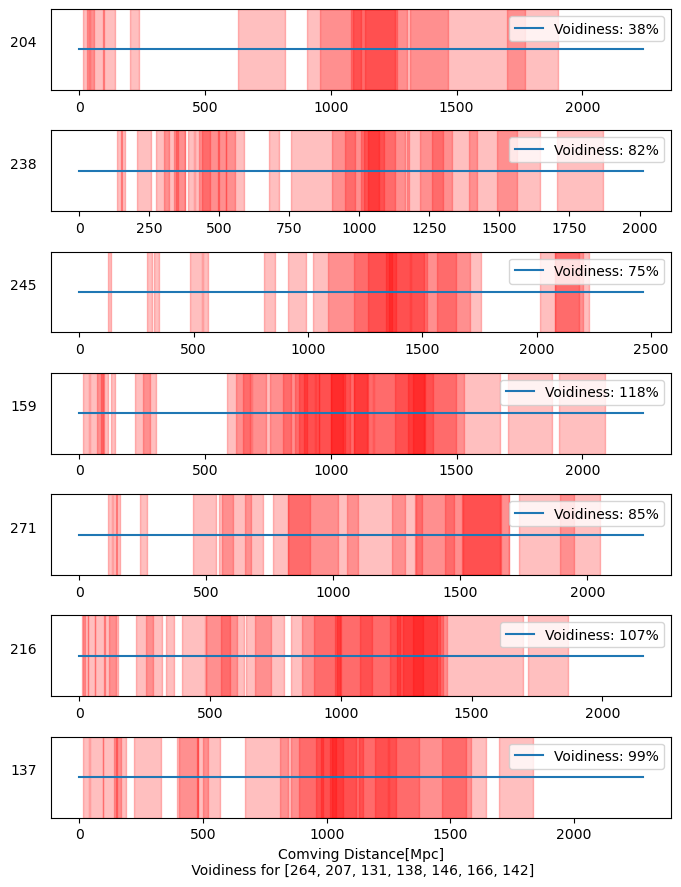

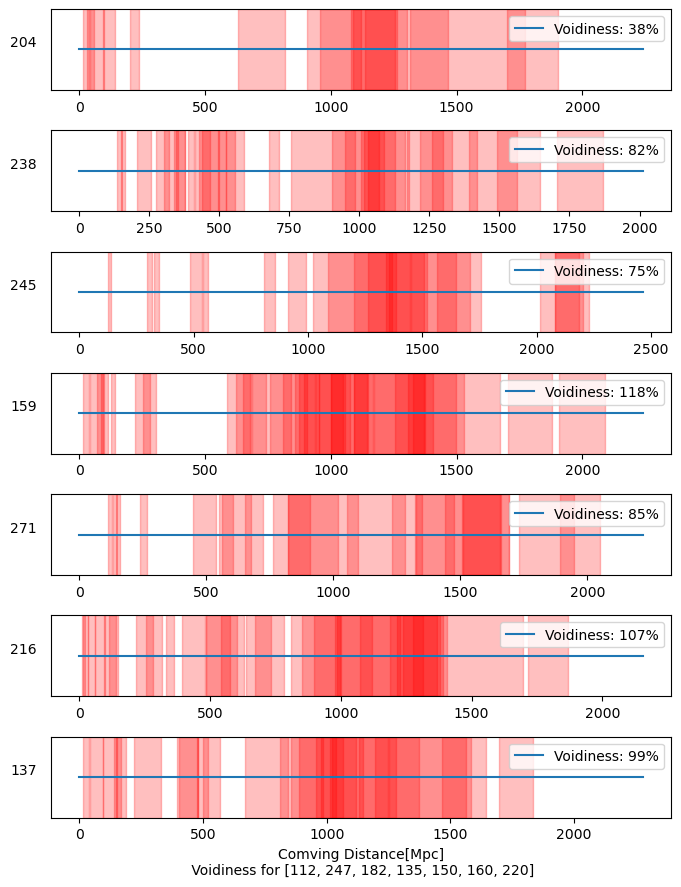

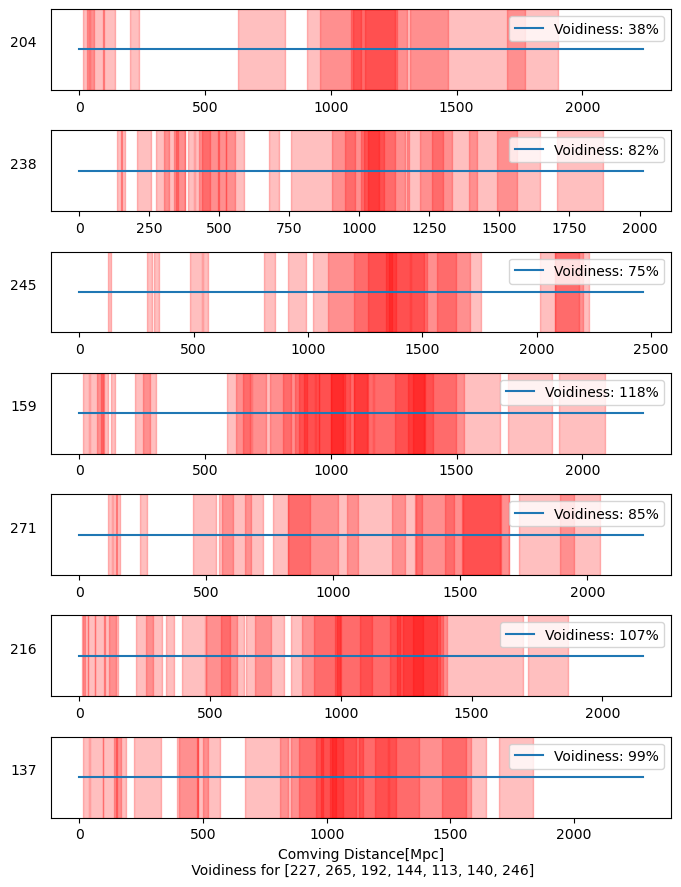

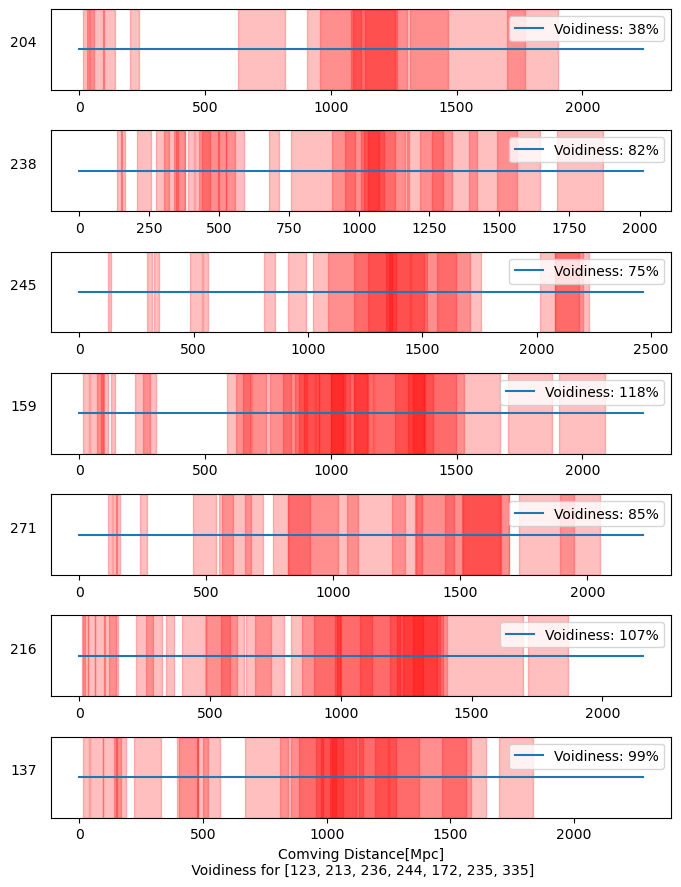

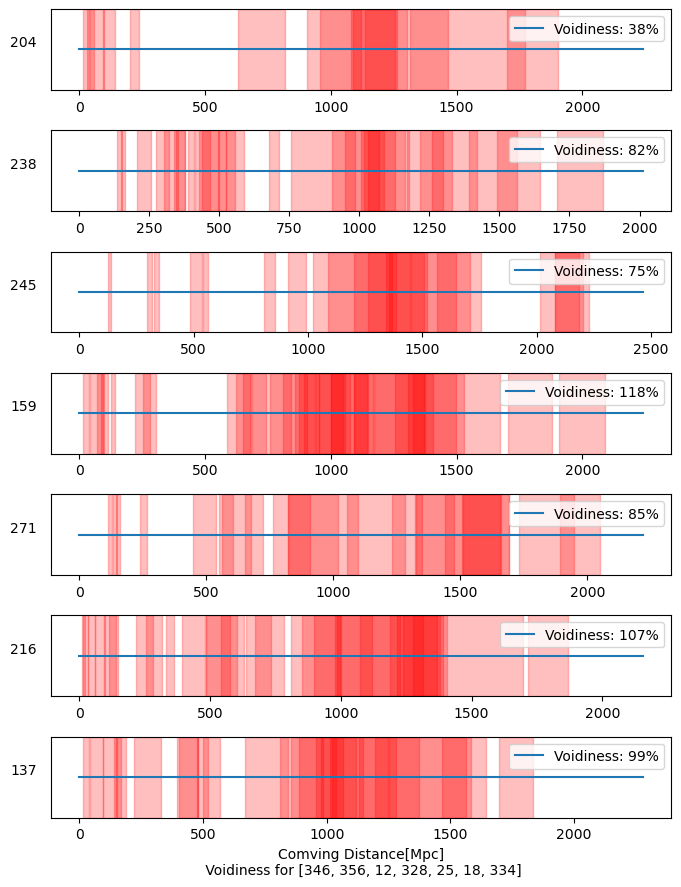

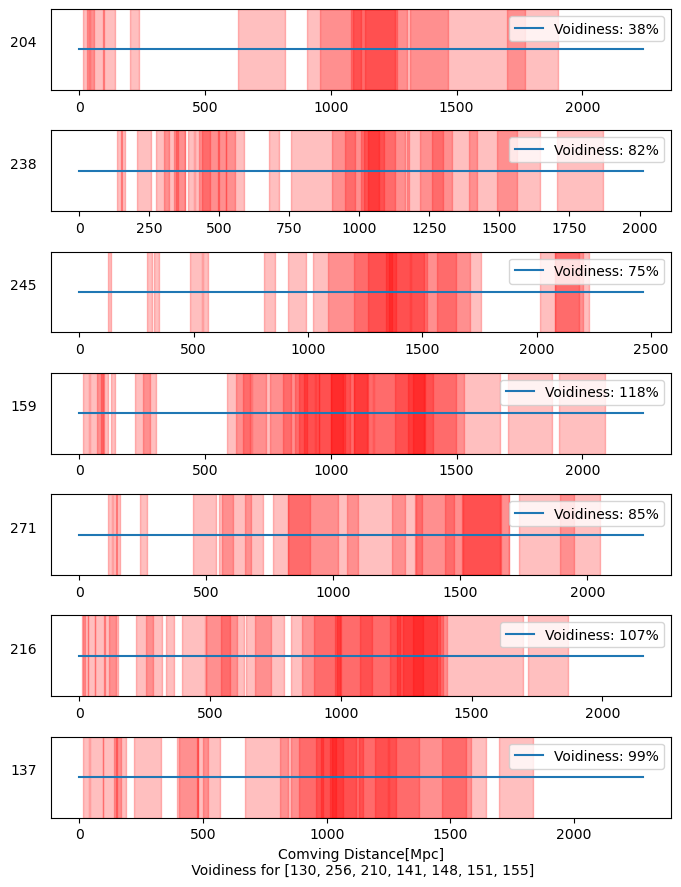

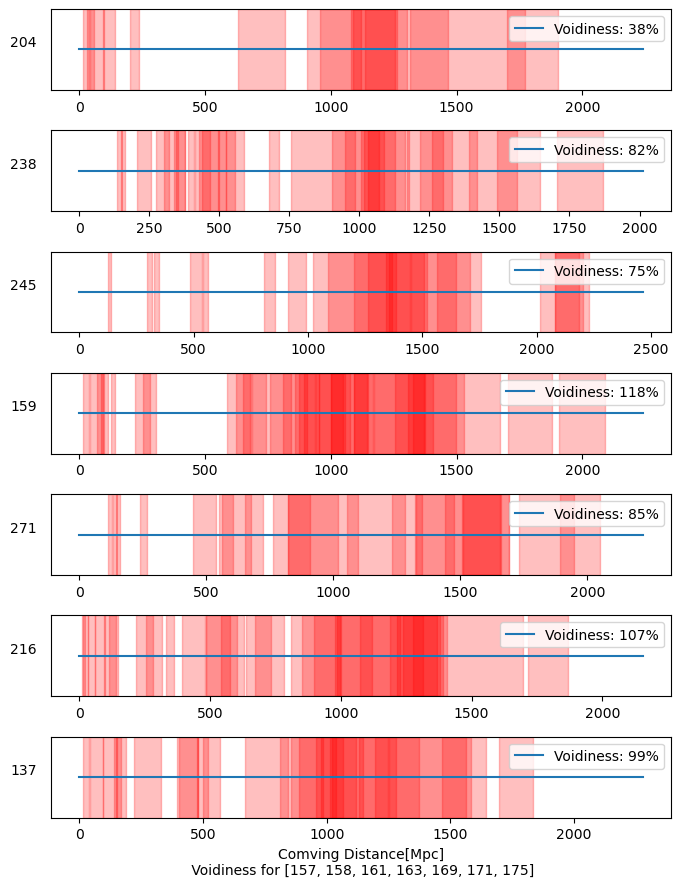

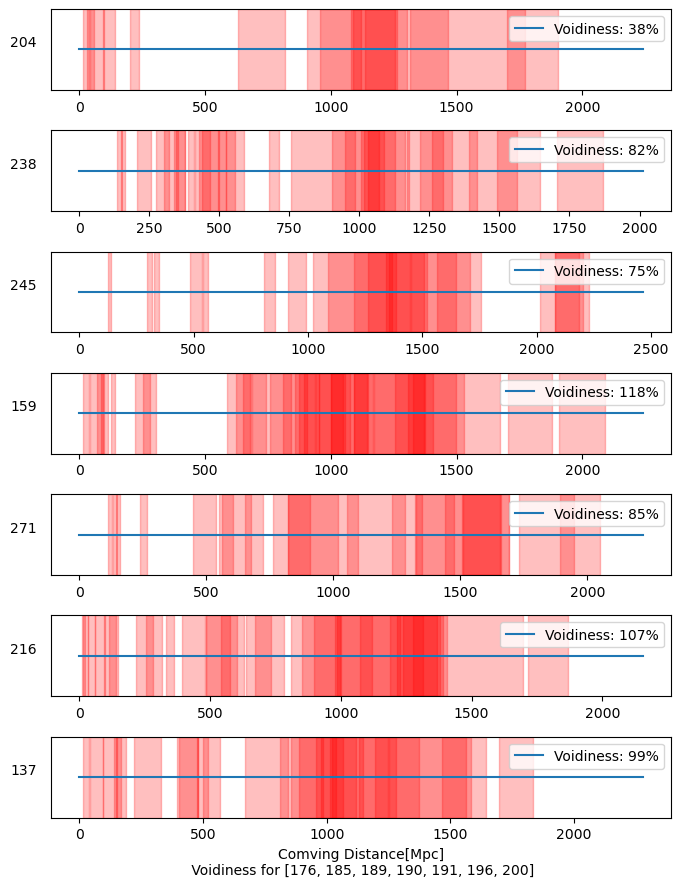

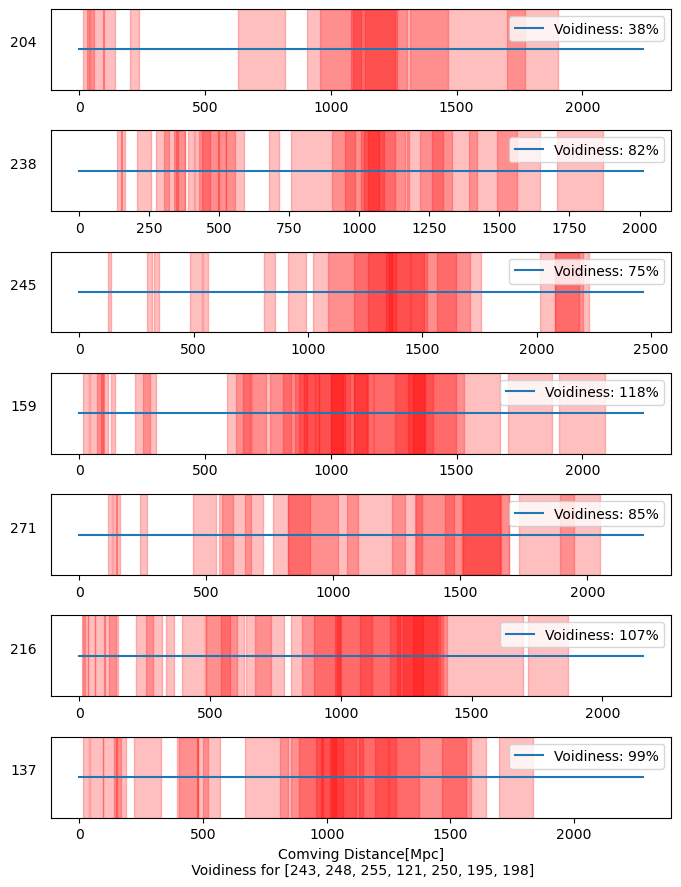

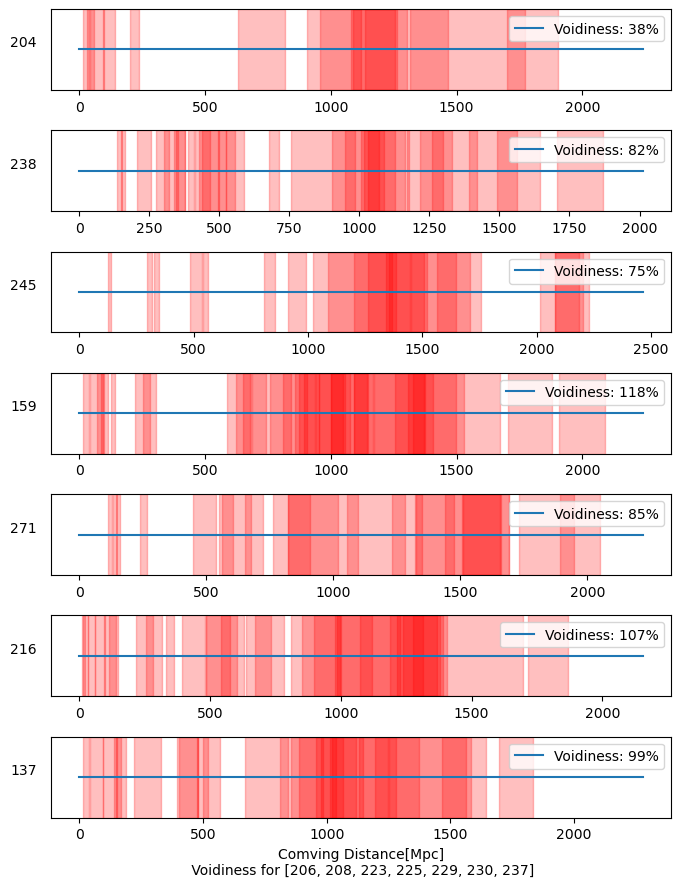

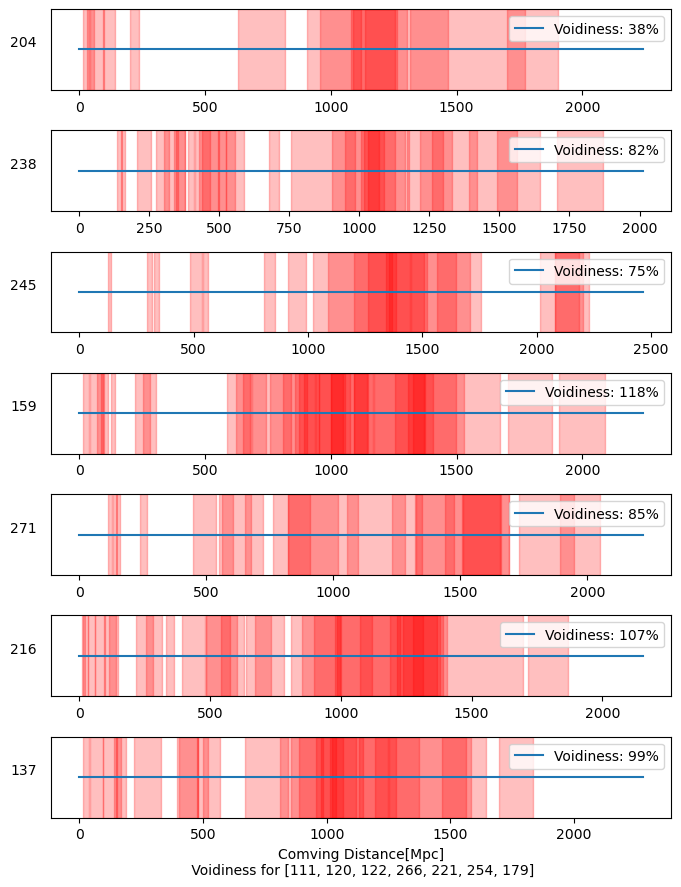

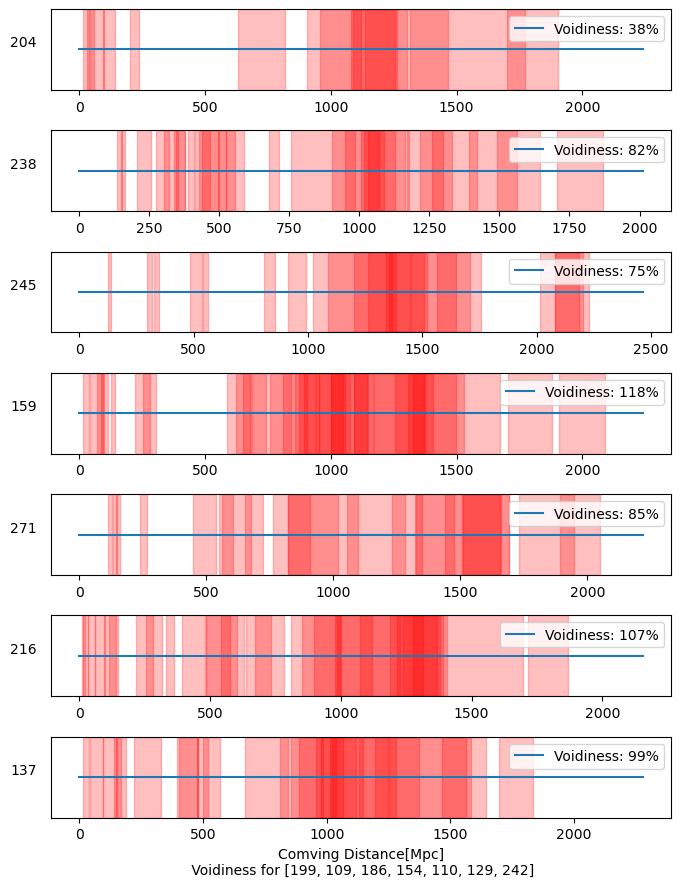

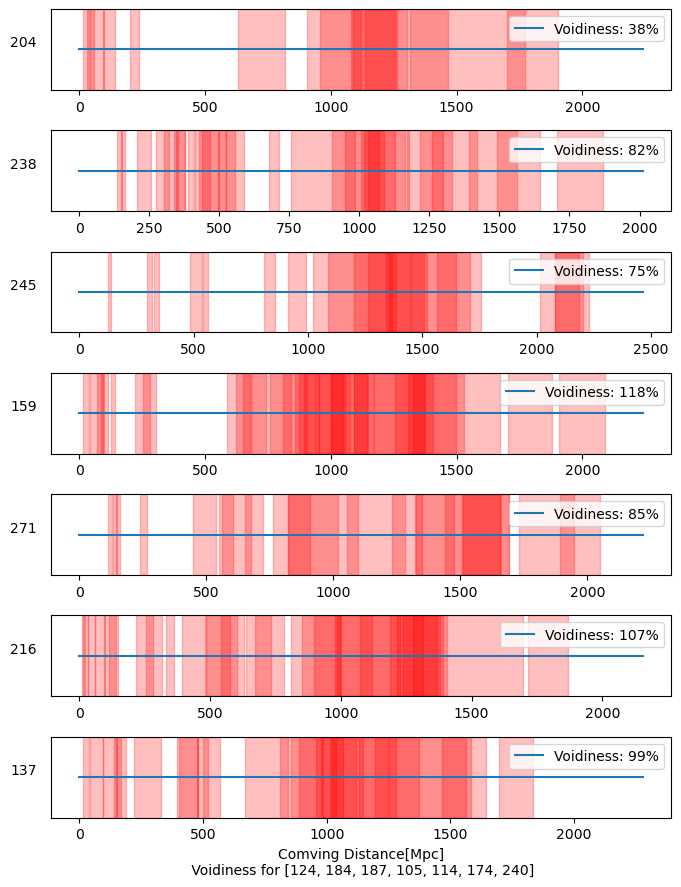

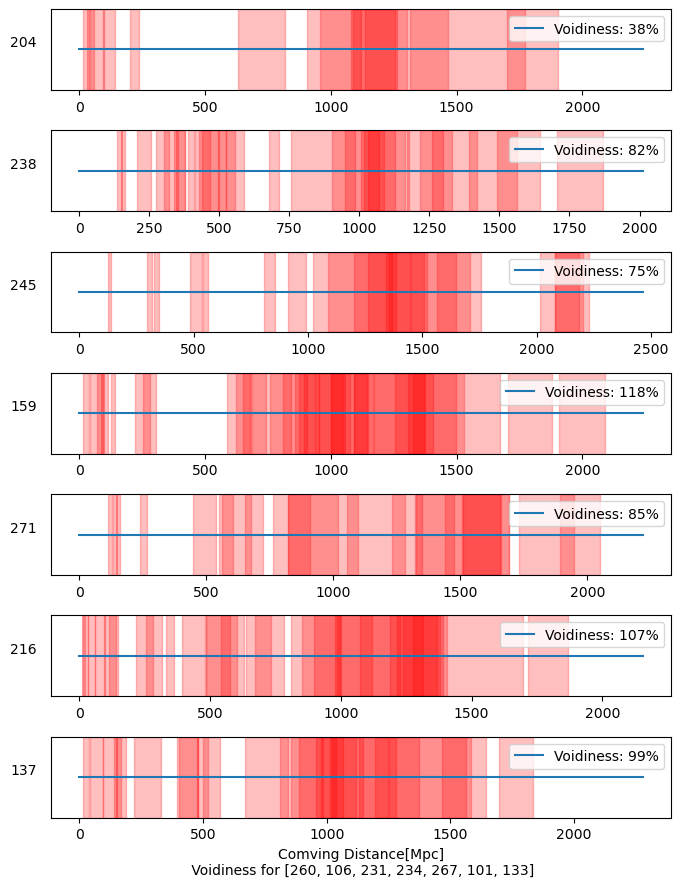

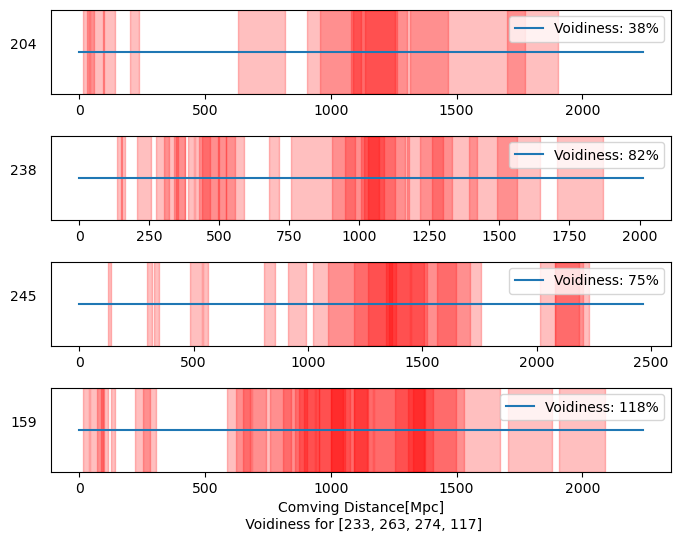

In [75]:
# Declaring some initial variables
num_r = 7 # Number of rows per subplot
width = 8 # 8 in. 
dr = "./output_plots/Voidiness_line_plots/" # Directory to save plots

# Chop up large list of GRS indices into sublists~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
n_full_rows  = len(src_keys)//num_r # Number of full rows without empty gaps
rem = len(src_keys)%num_r # Remainder 

chopped_keys = []
for i in range(n_full_rows):
    # Grab i'th group of num_r src keys
    chopped_keys.append(src_keys[0+num_r*i:num_r*(i+1)])

if rem:
    chopped_keys.append(src_keys[-rem:])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Batch count number and save plots
batch_no = 1
total_batches = len(chopped_keys)
for sub_list in chopped_keys:
    sub_len = len(sub_list)

    fig, axs = plt.subplots(nrows=sub_len, figsize=(width, sub_len*1.5))

    for grs, ax in zip(src_keys, axs.flat):
        

        voidiness_i = voidiness[grs] # Voidiness percent

        # TODO: Should this be in redshift? Going with CMVD for now
        cmvd_i = work_vhe.loc[grs, 'cmvd_Mpc'] # Comoving distance to GRS

        v_id = vhes[grs]['void_idx'] # Incident void Ids with current GRS

        # Create ranges of voidiness to show on plot~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        v_cmvd_mpc = work_voids.loc[v_id, 'cmvd_Mpc'].values
        v_r_mpc = work_voids.loc[v_id, 'Reff_Mpc'].values

        void_ranges = []
        for o, r in zip(v_cmvd_mpc, v_r_mpc):
            void_ranges.append((o-r, o+r))


        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        ax.plot([0,cmvd_i],[1,1])
        ax.set_ylabel(grs, rotation=0, labelpad=20)
        ax.set_yticks([])
        # ax.set_xlabel("Comoving Distance [Mpc]")
        ax.legend([f"Voidiness: {voidiness_i*100:.0f}%"], loc="upper right")

        # Color in voidy regions
        for start, end in void_ranges:
            ax.axvspan(start, end, color='red', alpha=0.25)

    # plt.title(f"Voidiness for{sub_list}")
    plt.xlabel(f"Comving Distance[Mpc]\n Voidiness for {sub_list}")

    plt.subplots_adjust(hspace=0.5)
    
 
    plt.savefig(dr + f"Batch_no_{batch_no}_of_{total_batches}.jpg")
    batch_no += 1





In [71]:
plt.rcdefaults()

In [49]:
work_voids.loc[pls,'cmvd_Mpc'].values

array([1801.53610081, 1364.6014025 , 1390.08196871, 1175.98063665,
       1168.47682516,   69.85917864,  116.59950117,   45.65165466,
         25.61309791,  219.55465702,  724.76755416, 1218.6726204 ,
       1013.09675697])

In [50]:
work_voids

,ID,RAdeg,DEdeg,z,Reff,DR,label,cmvd_Mpc,Reff_Mpc,r_ang_deg
0,60,114.782,37.641,0.64800,32.298,12,Mao,2389.186928,46.338594,1.111120
1,10020,184.261,1.326,0.50000,15.964,12,Mao,1916.069417,22.903874,0.684857
2,11496,124.855,3.090,0.64800,52.473,12,Mao,2389.186928,75.284075,1.804812
3,15935,230.976,13.239,0.45900,38.683,12,Mao,1777.677557,55.499283,1.788200
4,4407,237.406,16.985,0.46300,63.467,12,Mao,1791.322692,91.057389,2.909982
...,...,...,...,...,...,...,...,...,...,...
6366,81748,200.350,23.440,0.63004,41.540,10,cmass3,2333.924432,59.598278,1.462767
6367,60588,162.750,12.590,0.67881,37.440,10,cmass3,2482.646384,53.715925,1.239490
6368,102343,203.950,8.520,0.66704,37.300,10,cmass3,2447.141939,53.515065,1.252767
6369,51804,235.030,31.090,0.62018,27.510,10,cmass3,2303.337838,39.469154,0.981703


In [ ]:
fig, ax = plt.subplots(nrows=10, figsize=(8,14))
ax[0].set_ylabel("ewe")

# Statistical Analysis

### Distance Histograms

#### Prelim Histograms for Debugging

In [ ]:
# Defining some Useful base plotting parameters
xlabel = 'Distance Deg'
ylabel = 'Count'
base_title = 'Distances.'

##### Fermi Data

In [ ]:
vhe_seps = dist_w_skycoord(vhe_coords_gal) 
# verify_combo_count(vhe_seps, n=len(vhe_coords_gal)) # If its quiet we are good. 

##### Random Data

In [ ]:
if masked:
    mask = MASK_deg # apply 10 degree mask
else:
    mask = 0 # no mask
rand_coords_gal = generate_rand_Coords_static(len(vhe_coords_cel), mask = mask, seeded=False)
rand_coords_cel = rand_coords_gal.fk5 # book keeping

In [ ]:
rand_seps = dist_w_skycoord(rand_coords_gal)

In [ ]:
labels = ["FERMI", "Random Data"]

In [ ]:
plot_hist([vhe_seps, rand_seps],
          label=labels,
          xlabel = xlabel,
          ylabel = 'Percent',
          title = base_title + f' Masked: {masked}',
        #   bins = 3,
        # histtype='bar',
        # stacked=True,
          )

In [ ]:
plot_hist([vhe_coords_gal.l.value, rand_coords_gal.l.value],
          label=labels,
          title = f'Galactic Longitude (l) Distribution. Masked: {masked}',
          xlabel = 'Angle Deg',
          ylabel = 'Percent',
          bins=75)
plot_hist([vhe_coords_gal.b.value, rand_coords_gal.b.value],
          label = labels,
          title = f'Galactic Latitude (b) Distribution. Masked: {masked}',
          xlabel = 'Angle Deg',
          ylabel = 'Percent',
          bins=75)

In [ ]:
# generate_rand_l_and_b(1000) # quickly testing they are independen distributions

In [ ]:
# Fermi and Random plot in Celestial
ax = plt.axes(projection="geo aitoff")
ax.grid()
rand_coords_cel
ax.scatter(rand_coords_cel.ra.deg, rand_coords_cel.dec.deg,
           transform=ax.get_transform('world'),
           s=1,
           marker='o',
           label='Random Points',
        )
ax.scatter(vhe_coords_cel.ra.deg, vhe_coords_cel.dec.deg,
           transform=ax.get_transform('world'),
           s=1,
           marker='o',
           label='Fermi Data',
        )
plt.legend(loc="lower right")
plt.title(f"Coordinate Skymap, Celestial, Mask: {masked}")

In [ ]:
# Fermi and and random plot in galactic
ax = plt.axes(projection="geo aitoff")
ax.grid()
rand_coords_cel
ax.scatter(rand_coords_gal.spherical.lon.deg, rand_coords_gal.spherical.lat.deg,
           transform=ax.get_transform('world'),
           s=1,
           marker='o',
           label='Random Points',
        )
ax.scatter(vhe_coords_gal.spherical.lon.deg, vhe_coords_gal.spherical.lat.deg,
           transform=ax.get_transform('world'),
           s=1,
           marker='o',
           label='Fermi Data',
        #    c=void_table['z'],
        #    alpha = 0.4
        )
plt.legend(loc="lower right")
plt.title(f"Coordinate Skymap, Galactic, Mask: {masked}")

In [ ]:
pls = generate_rand_Coords_static(len(vhe_coords_cel))

In [ ]:
len(vhe_coords_cel)

#### Little Bit to figure out average number of coordinates cut out. 

In [ ]:
# Little bit of code to figure out mean number of coordinates cut out by mask
# Then add them to total number of random coordinates generated


# if True:
#     n = 10000000
#     n_coords = np.zeros(n)
#     len_vhe = len(vhe_coords)
#     with Pool(12) as p:
#         n_coords = p.map(len_gen_coords, [len_vhe] * n)

#     mean_n_cut = len_vhe - np.mean(n_coords) # 211 from 10,000,000 samplings

#### Sampling and Analysis

In [ ]:
# 1000 samples block takes ~ 5 min
n_coords = len(vhe_coords_gal) # number of coordinates to produce
n_samples = 10
BATCH_COUNT = 1

file_name = f'./Random_Data/test_{BATCH_COUNT}.pickle'
for i in range(10):
    with Pool(12) as p:
        rand_seps = p.map(sample_and_measure, [n_coords]*n_samples) # Nested list
    
    if BATCH_COUNT % 10 ==0: # Multiple of 10
        BATCH_COUNT += 1
        file_name = f'test_{BATCH_COUNT}.pickle'

    # Save rand_seps into a CSV file, overwriting the file each time.
    with open(file_name, 'ab') as file:
        pickle.dump(rand_seps, file)
    

In [ ]:
with open(file_name, 'rb') as file:
    save_data = pickle.load(file)

Take mean,for a single bin.

In [ ]:
flattened_seps = list(chain.from_iterable(rand_seps)) # Chain is faster

In [ ]:
# df = pd.DataFrame(rand_seps) # 2 mins for a 50 x 544,446 table. maybe pandas is not the way to go. 
# # if this was a 1000 table. this would take significantly longer.

In [ ]:
n_bins = 180
bins = np.linspace(0,180, n_bins + 1)

In [ ]:
# bin_indices = np.digitize(rand_seps, bins) - 1 # To fix 0 indexing


In [ ]:
# bin_indices

In [ ]:
# print(bin_indices == 89)

In [ ]:
# test_bi = bin_indices[0]

In [ ]:
# pandas has methods for handling large data sets
# df = pd.DataFrame({"Seperations": flattened_seps, "Bin": bin_indices})

In [ ]:
# bin_statistics = df.groupby('Bin')['Seperations'].agg(['mean', 'std'])

In [ ]:

plot_hist([vhe_seps, flattened_seps],
          label=['FERMI', 'Random Data', '1 Sigma'],
          xlabel = xlabel,
          ylabel = 'Percent',
          title = base_title + f' Masked: {masked}',
        #   bins = 3,
        # histtype='bar',
        # stacked=True,
          )